In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import cv2
import opencv_jupyter_ui
import matplotlib.pyplot as plt
from collections import defaultdict
import calendar

In [2]:
#Read in the data
data = pd.read_csv("Lekagul Sensor Data.csv")
data

,Timestamp,car-id,car-type,gate-name
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2
...,...,...,...,...
171472,2016-05-31 23:40:13,20161031111001-854,6,ranger-stop2
171473,2016-05-31 23:42:08,20165831105856-579,1,general-gate4
171474,2016-05-31 23:43:13,20161031111001-854,6,general-gate1
171475,2016-05-31 23:49:45,20165831105856-579,1,general-gate7


In [3]:
#Check each column's data type
data.dtypes

Timestamp    object
car-id       object
car-type     object
gate-name    object
dtype: object

In [4]:
#Check for nulls
data.isna().sum()

Timestamp    0
car-id       0
car-type     0
gate-name    0
dtype: int64

In [5]:
#Change variables to appropriate type
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['car-type'] = data['car-type'].astype('category')
data['gate-name'] = data['gate-name'].astype('category')
#data[['car_id1', 'car_id2']] = data['car-id'].str.split('-', expand=True)
#data['car_id1'] = pd.to_numeric(data['car_id1'])
#data['car_id2'] = pd.to_numeric(data['car_id2'])
#data = data.drop('car-id', axis=1)
data

,Timestamp,car-id,car-type,gate-name
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2
...,...,...,...,...
171472,2016-05-31 23:40:13,20161031111001-854,6,ranger-stop2
171473,2016-05-31 23:42:08,20165831105856-579,1,general-gate4
171474,2016-05-31 23:43:13,20161031111001-854,6,general-gate1
171475,2016-05-31 23:49:45,20165831105856-579,1,general-gate7


In [6]:
#Check each column's data type again
data.dtypes

Timestamp    datetime64[ns]
car-id               object
car-type           category
gate-name          category
dtype: object

In [7]:
#Describe the statistics of the base data
data.describe()

/var/folders/dq/pfq3tvqs1wv176zp5xp2dfs80000gn/T/ipykernel_5185/2146467897.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,Timestamp,car-id,car-type,gate-name
count,171477,171477,171477,171477
unique,170298,18708,7,40
top,2015-07-31 12:00:02,20154519024544-322,1,general-gate7
freq,5,281,67698,16119
first,2015-05-01 00:43:28,NaN,NaN,NaN
last,2016-05-31 23:56:06,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'Timestamp'}>]], dtype=object)

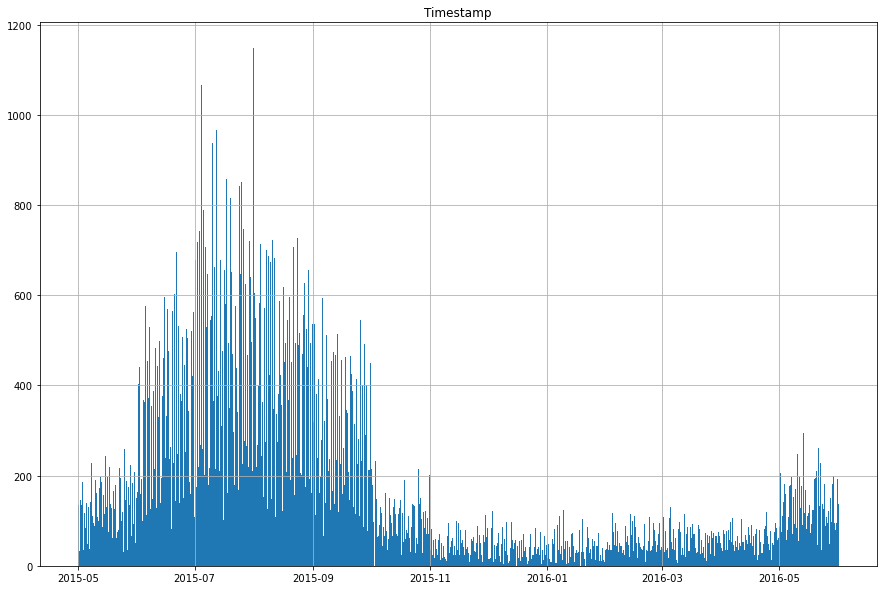

In [8]:
#Visualize distribution of each column & outliers
data.hist(bins=1000, figsize=(15, 10))

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


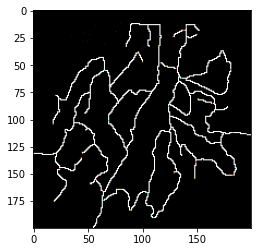

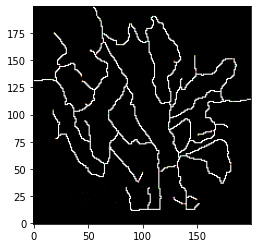

(<matplotlib.image.AxesImage at 0x1259f83a0>, None, None)

In [9]:
#load in bmp
img = cv2.imread('Lekagul Roadways.bmp')
flip = img[::-1,:,:]
#bmp = img.convert(mode="RGB")
pixel_values = flip[:,:,::-1]
print(pixel_values)
plt.imshow(flip[:,:,::-1],vmin=0,vmax=255), plt.show()
plt.imshow(flip[:,:,::-1]), plt.gca().invert_yaxis(), plt.show()

In [10]:
print(pixel_values[0])

#color names

# (0, 0, 0), black
#  (0, 255, 255), cyan
#  (1, 1, 1), black
#  (2, 2, 2), black
#  (3, 3, 3), black
#  (5, 5, 5), black
#  (6, 6, 6), black
#  (8, 8, 8), black
#  (9, 9, 9), black
#  (14, 14, 14), black
#  (16, 16, 16),black
#  (17, 17, 17),black
#  (18, 18, 18),black
#  (19, 19, 19),black
#  (20, 20, 20),black
#  (21, 21, 21),black
#  (22, 22, 22),black
#  (23, 23, 23),black
#  (24, 24, 24),black
#  (25, 25, 25),black
#  (31, 31, 31),black
#  (46, 46, 46),black
#  (64, 64, 64),black
#  (65, 65, 65),black
#  (66, 66, 66),black
#  (67, 67, 67),black
#  (68, 68, 68),black
#  (70, 70, 70),black
#  (72, 72, 72),black
#  (76, 255, 0),green
#  (239, 239, 239),yellow
#  (255, 0, 0),red
#  (255, 0, 220),pink
#  (255, 106, 0),orange
#  (255, 216, 0),orange
#  (255, 255, 255)white

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 

In [11]:
#create np.array grid
# replace color values with sensor names
# 'R' signifies a road
# '.' signifies empty space
grid = [['.' for i in range(200)] for j in range(200)]

for y in range(len(pixel_values)):
    for x in range(len(pixel_values[y])):
        if (pixel_values[x][y] == [0, 255, 255]).all():
            grid[x][y] = 'General_Gate'
        elif (pixel_values[x][y] == [76, 255, 0]).all():
            grid[x][y] = 'Entrance'
        elif ((pixel_values[x][y] == [255, 216, 0]).all()):
            grid[x][y] = 'Ranger_Stop'
        elif (pixel_values[x][y] == [255, 0, 0]).all():
            grid[x][y] = 'Gate'
        elif (pixel_values[x][y] == [255, 0, 220]).all():
            grid[x][y] = 'Ranger_Base'
        elif (pixel_values[x][y] == [255, 106, 0]).all():
            grid[x][y] = 'Camping'
        elif (pixel_values[x][y] == [255, 255, 255]).all():
            grid[x][y] = 'R'
        else:
            continue

print(grid)

[['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

In [12]:
#get just the coordinates of the sensors

color_map = []
for x in range(len(grid)):
    for y in range(len(grid[x])):
        if grid[x][y] == ".":
            continue
        else:
            color_map.append([grid[x][y], (y,x)])

print(color_map)

[['R', (90, 12)], ['R', (91, 12)], ['R', (92, 12)], ['R', (93, 12)], ['R', (94, 12)], ['R', (95, 12)], ['R', (96, 12)], ['R', (97, 12)], ['R', (89, 13)], ['R', (90, 13)], ['R', (97, 13)], ['R', (98, 13)], ['R', (99, 13)], ['R', (100, 13)], ['R', (101, 13)], ['R', (102, 13)], ['R', (103, 13)], ['R', (104, 13)], ['R', (105, 13)], ['R', (106, 13)], ['R', (107, 13)], ['R', (108, 13)], ['R', (109, 13)], ['R', (110, 13)], ['R', (111, 13)], ['R', (112, 13)], ['R', (113, 13)], ['R', (114, 13)], ['R', (115, 13)], ['R', (116, 13)], ['R', (140, 13)], ['R', (141, 13)], ['R', (142, 13)], ['R', (143, 13)], ['R', (144, 13)], ['R', (145, 13)], ['R', (146, 13)], ['R', (147, 13)], ['R', (148, 13)], ['R', (89, 14)], ['R', (105, 14)], ['R', (116, 14)], ['R', (140, 14)], ['R', (148, 14)], ['R', (89, 15)], ['R', (105, 15)], ['R', (116, 15)], ['Entrance', (140, 15)], ['R', (148, 15)], ['R', (149, 15)], ['R', (89, 16)], ['R', (105, 16)], ['R', (116, 16)], ['R', (140, 16)], ['R', (149, 16)], ['R', (150, 16)], 

In [13]:
#Still having issues with x,y axis
# Flipped coordinates for color mapping in grid
sensors_dict = defaultdict(list)
for x in color_map:
    if x[0] == 'R':
        continue
    else:
        sensors_dict[x[0]].append(x[1])

print(sensors_dict)

#'Entrance':
#   (140, 15) 4
#   (115, 32) 3
#   (183, 112) 2
#   (17, 132) 1
#   (62, 186) 0
#'Gate':
#   (138, 18) 8
#   (97, 39) 7
#   (116, 48) 6
#   (131, 53) 5
#   (164, 85) 4
#   (149, 139) 3
#   (24, 145) 2
#   (58, 155) 1
#   (63, 166) 0
#'Camping':
#   (150, 22) 6
#   (181, 54) 7
#   (20, 78) 5
#   (48, 110) 4
#   (45, 131) 2
#   (44, 135) 3
#   (129, 149) 1
#   (183, 151) 8
#   (52, 158) 0
#'Ranger_Base':
#   (128, 24)
#'Ranger_Stop':
#   (100, 47) 7
#   (123, 52) 6
#   (151, 81) 5
#   (18, 104) 4
#   (148, 154) 3
#   (80, 164) 2
#   (19, 175) 1
#   (89, 183) 0
#'General_Gate':
#   (65, 55) 7
#   (136, 62) 6
#   (124, 88) 5
#   (69, 101) 4
#   (186, 144) 3
#   (104, 167) 2
#   (64, 174) 1
#   (110, 190) 0

defaultdict(<class 'list'>, {'Entrance': [(140, 15), (115, 32), (183, 112), (17, 132), (62, 186)], 'Gate': [(138, 18), (97, 39), (116, 48), (131, 53), (164, 85), (149, 139), (24, 145), (58, 155), (63, 166)], 'Camping': [(150, 22), (181, 54), (20, 78), (48, 110), (45, 131), (44, 135), (129, 149), (183, 151), (52, 158)], 'Ranger_Base': [(128, 24)], 'Ranger_Stop': [(100, 47), (123, 52), (151, 81), (18, 104), (148, 154), (80, 164), (19, 175), (89, 183)], 'General_Gate': [(65, 55), (136, 62), (124, 88), (69, 101), (186, 144), (104, 167), (64, 174), (110, 190)]})


In [14]:
#dictionary with car id and car type as key
car_id_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    car_id_dict[(data['car-id'][x], data['car-type'][x])].append((data['Timestamp'][x], data['gate-name'][x]))

In [15]:
#dictionary with timestamp as key
time_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    time_dict[data['Timestamp'][x]].append((data['car-id'][x], data['gate-name'][x], data['car-type'][x]))


In [16]:
#dictionary with vehicle type as key
car_type_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    car_type_dict[data['car-type'][x]].append((data['Timestamp'][x], data['gate-name'][x], data['car-id'][x]))



In [17]:
#dictionary with sensor name as key
gate_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    gate_dict[data['gate-name'][x]].append((data['car-id'][x], data['Timestamp'][x], data['car-type'][x]))


In [18]:
#create graph class


class Graph(object):

    def __init__(self, graph_dict=None):
        if graph_dict == None:
            graph_dict = {}
        self._graph_dict = graph_dict
    def edges(self, vertex):
        return self._graph_dict[vertex]
    def all_vertices(self):
        return set(self._graph_dict.keys())
    def all_edges(self):
        return self._generate_edges()
    def add_vertex(self, vertex):
        if vertex not in self._graph_dict:
            self._graph_dict[vertex] = []
    def add_edge(self, edge):
        edge = set(edge)
        v1, v2 = tuple(edge)
        for x, y in [(v1, v2), (v2, v1)]:
            for x in self._graph_dict:
                self._graph_dict[x].add(y)
            else:
                self._graph_dict[x] = [y]
    def _generate_edges(self):
        edges = []
        for vertex in self._graph_dict:
            for neighbor in self._graph_dict[vertex]:
                if {neighbor, vertex} not in edges:
                    edges.append({vertex, neighbor})
        return edges
    def __iter__(self):
        self._iter_obj = iter(self._graph_dict)
        return self._iter_obj
    def __next__(self):
        return next(self._iter_obj)
    def __str__(self):
        res = "vertices: "
        for k in self._graph_dict:
            res += str(k) + " "
        res += "\nedges: "
        for edge in self._generate_edges():
            res += str(edge) + " "
        return res

In [19]:
#create graph of all sensors

g = {"Entrance_0": {'General_gate_1', 'Gate_0', 'General_gate_4', 'General_gate_7', 'Gate_7', 'Gate_6', 'Entrance_3'},
     "Entrance_1": {'Gate_2', 'Camping_2', 'Camping_3', 'Camping_4', 'Camping_0', 'Gate_1', 'General_gate_7'},
     "Entrance_2": {'General_gate_3', 'Gate_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2', 'General_gate_5', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "Entrance_3": {'Gate_6', 'Gate_7', 'General_gate_7', 'General_gate_4', 'Gate_0', 'General_gate_1', 'Entrance_0'},
     "Entrance_4": {'Gate_8', 'Camping_6', 'Gate_5', 'General_gate_6', 'Gate_4', 'Entrance_2', 'General_gate_3', 'General_gate_5', 'Gate_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "Gate_0": {'Gate_1', 'Entrance_0', 'General_gate_1', 'General_gate_4', 'Gate_6', 'Entrance_3', 'General_gate_7', 'Gate_7'},
     "Gate_1": {'Camping_0', 'Gate_0', 'Camping_3', 'Camping_4', 'Entrance_1', 'Gate_2', 'Camping_2', 'General_gate_7'},
     "Gate_2": {'Ranger_stop_1', 'Camping_2', 'Entrance_1', 'Camping_4', 'Camping_3', 'Camping_0', 'Gate_1', 'General_gate_7'},
     "Gate_3": {'Ranger_stop_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2', 'General_gate_5', 'General_gate_3', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "Gate_4": {'Ranger_stop_5', 'Entrance_2', 'General_gate_3', 'General_gate_5', 'Gate_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "Gate_5": {'Ranger_stop_6', 'Camping_6', 'Gate_8', 'Entrance_4', 'General_gate_6', 'General_gate_5', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Camping_8', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_0'},
     "Gate_6": {'Ranger_stop_6', 'Entrance_3', 'Entrance_0', 'General_gate_1', 'Gate_0', 'General_gate_4', 'General_gate_7', 'Gate_7'},
     "Gate_7": {'Ranger_stop_7', 'General_gate_7', 'General_gate_4', 'Gate_6', 'Entrance_3', 'Gate_0', 'General_gate_1', 'Entrance_0'},
     "Gate_8": {'Ranger_base', 'Entrance_4', 'Camping_6', 'Gate_5', 'General_gate_6', 'General_gate_5', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Camping_8', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "Camping_0": {'Gate_1', 'Camping_3', 'Camping_4', 'Entrance_1', 'Gate_2', 'Camping_2', 'General_gate_7'},
     "Camping_1": {'General_gate_0', 'General_gate_2', 'General_gate_5', 'Gate_3', 'Camping_8', 'General_gate_3', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "Camping_2": {'Gate_2', 'Entrance_1', 'Camping_4', 'Camping_3', 'Camping_0', 'Gate_1', 'General_gate_7'},
     "Camping_3": {'Gate_1', 'Camping_0', 'Camping_4', 'Entrance_1', 'Gate_2', 'Camping_2', 'General_gate_7'},
     "Camping_4": {'General_gate_7', 'Gate_1', 'Camping_0', 'Camping_3', 'Entrance_1', 'Gate_2', 'Camping_2'},
     "Camping_5": {'Ranger_stop_4', 'General_gate_7'},
     "Camping_6": {'Entrance_4', 'Gate_8', 'Gate_5', 'General_gate_6', 'General_gate_5', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Gate_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "Camping_7": {'General_gate_6'},
     "Camping_8": {'General_gate_3', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2', 'General_gate_5', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "General_gate_0": {'General_gate_2', 'Camping_1', 'Gate_3', 'Camping_8', 'General_gate_5', 'General_gate_3', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "General_gate_1": {'Entrance_0', 'Gate_0', 'Ranger_stop_2', 'General_gate_4', 'Gate_6', 'Entrance_3', 'General_gate_7', 'Gate_7'},
     "General_gate_2": {'Ranger_stop_0', 'General_gate_0', 'Camping_1', 'General_gate_5', 'Gate_3', 'Camping_8', 'General_gate_3', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "General_gate_3": {'Camping_8', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4', 'General_gate_5', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "General_gate_4": {'Entrance_0', 'General_gate_1', 'Gate_0', 'Gate_6', 'Entrance_3', 'Gate_7', 'General_gate_7'},
     "General_gate_5": {'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4', 'General_gate_6', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Camping_8', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "General_gate_6": {'Camping_7', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4', 'General_gate_5', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Camping_8', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "General_gate_7": {'Camping_5', 'Ranger_stop_4', 'Gate_7', 'General_gate_4', 'Gate_6', 'Entrance_3', 'Entrance_1', 'Gate_2', 'Camping_2', 'Camping_4', 'Camping_3', 'Camping_0', 'Gate_1', 'Gate_0', 'General_gate_1', 'Entrance_0'},
     "Ranger_stop_0": {'Ranger_stop_2', 'General_gate_2'},
     "Ranger_stop_1": {'Gate_2'},
     "Ranger_stop_2": {'Ranger_stop_0', 'General_gate_1'},
     "Ranger_stop_3": {'Gate_3'},
     "Ranger_stop_4": {'Camping_5', 'General_gate_7'},
     "Ranger_stop_5": {'Gate_4'},
     "Ranger_stop_6": {'Gate_5', 'Gate_6'},
     "Ranger_stop_7": {'Gate_7'},
     "Ranger_base": {'Gate_8'},
     }

g = Graph(g)

In [20]:
#sort card id dictionary by timestamp
#thi will show the 'path' of each car over time
car_sorted = {x:sorted(car_id_dict[x]) for x in car_id_dict.keys()}

In [21]:
#Example to make sure times are sorted ascending
print(car_id_dict[('20154301124328-262', '4')])

[(Timestamp('2015-05-01 00:43:28'), 'entrance3'), (Timestamp('2015-05-01 01:03:48'), 'general-gate1'), (Timestamp('2015-05-01 01:06:24'), 'ranger-stop2'), (Timestamp('2015-05-01 01:09:25'), 'ranger-stop0'), (Timestamp('2015-05-01 01:12:36'), 'general-gate2'), (Timestamp('2015-05-01 01:24:02'), 'general-gate5'), (Timestamp('2015-05-01 01:33:57'), 'entrance4')]


In [22]:
# track individual cars
print("Number of individual cars:",len(data['car-id'].unique()))

Number of individual cars: 18708


In [23]:
# separate out by month to see trends
data['month'] = [d.strftime('%b') for d in data.Timestamp]
data.head()

,Timestamp,car-id,car-type,gate-name,month
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3,May
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1,May
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2,May
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0,May
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2,May


<AxesSubplot:xlabel='month', ylabel='count'>

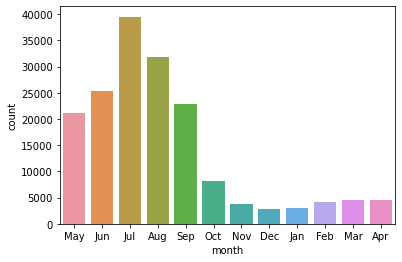

In [24]:
# visualize data overall
sns.countplot(x=data.month)

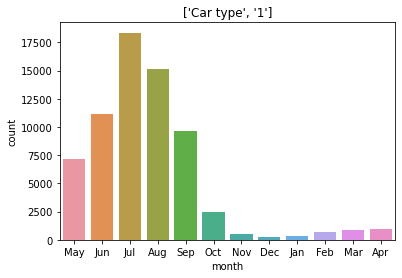

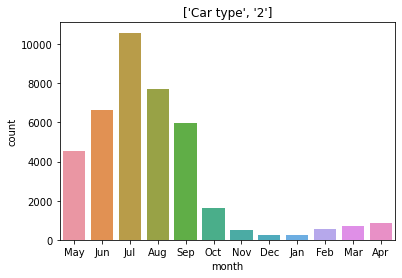

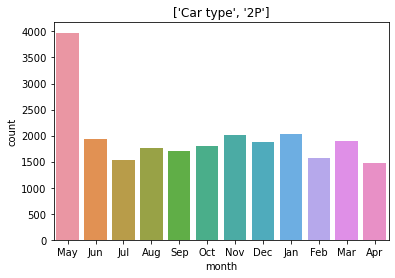

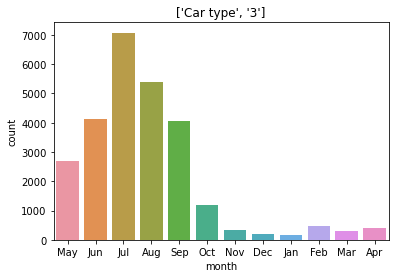

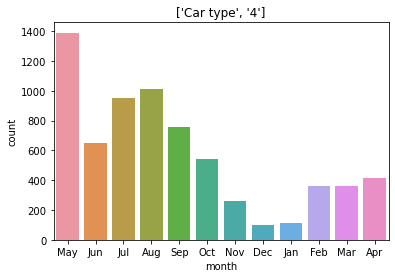

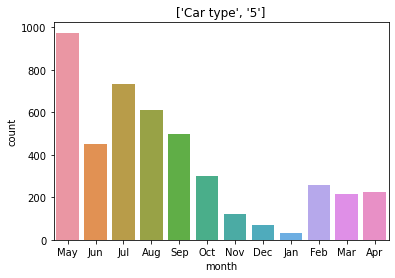

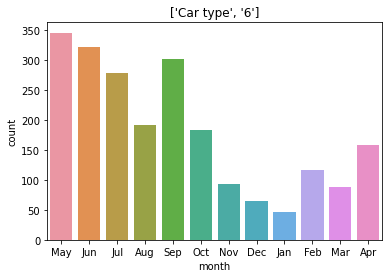

In [25]:
# visualize data grouped by car type and month
for t in sorted(data['car-type'].unique()):
    sns.countplot(x=data.month[data['car-type']==t]).set(title=["Car type", t])
    plt.show()

In [55]:
# separate out by weekdays
data['day'] = [calendar.day_name[int(d.weekday())] for d in data.Timestamp]
data['days'] = [d.weekday() for d in data.Timestamp]
data['hours'] = [d.hour for d in data.Timestamp]
data.head()

,Timestamp,car-id,car-type,gate-name,month,day,days,hours
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3,May,Friday,4,0
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1,May,Friday,4,1
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2,May,Friday,4,1
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0,May,Friday,4,1
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2,May,Friday,4,1


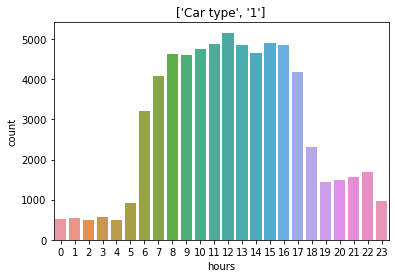

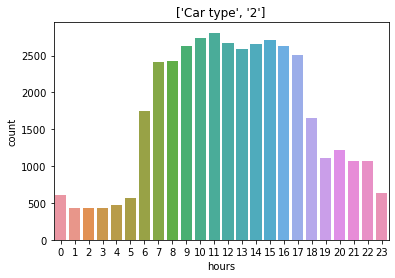

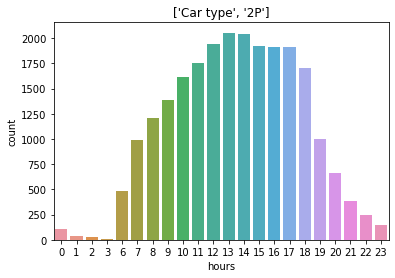

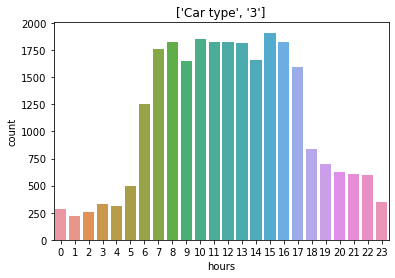

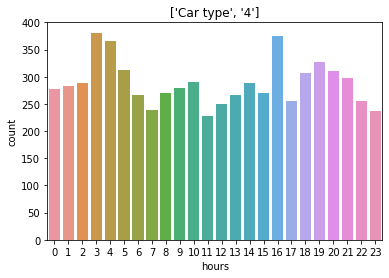

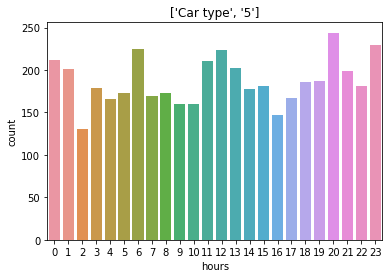

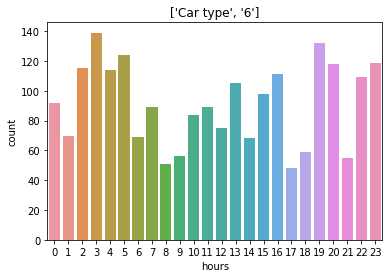

In [63]:
# visualize data grouped by car type and month
for t in sorted(data['car-type'].unique()):
    sns.countplot(x=data.hours[data['car-type']==t]).set(title=["Car type", t])
    plt.show()

<AxesSubplot:xlabel='month,days,car-type'>

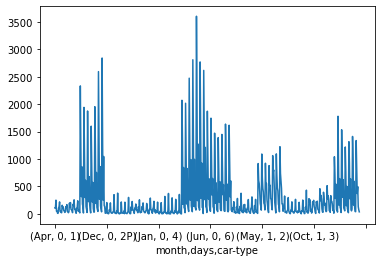

In [62]:
# this attempt gives no real information
groups = data.groupby(['month', 'days', 'car-type']).size()

In [30]:
# attempt to use pivot tables for visualization; 
info = data.pivot_table(index="month",columns="days",values="car-type",aggfunc="sum")
sns.heatmap(info)

/var/folders/dq/pfq3tvqs1wv176zp5xp2dfs80000gn/T/ipykernel_5185/3203605987.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.
  info = data.pivot_table(index="month",columns="days",values="car-type",aggfunc="sum")


ValueError: zero-size array to reduction operation fmin which has no identity

/var/folders/dq/pfq3tvqs1wv176zp5xp2dfs80000gn/T/ipykernel_5185/2698445692.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sns.heatmap(data.groupby(['month', 'days', 'car-type']).size()[:, np.newaxis])


<AxesSubplot:>

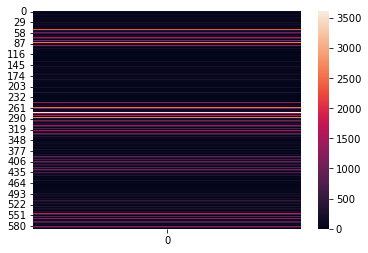

In [31]:
# a heatmap attempt 
sns.heatmap(data.groupby(['month', 'days', 'car-type']).size()[:, np.newaxis])

<AxesSubplot:>

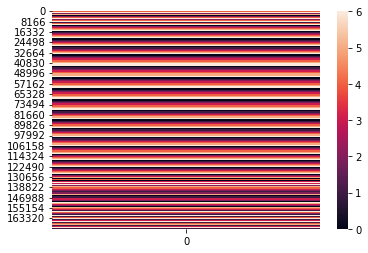

In [32]:
# another heatmap attempt
times = np.asarray(data.days).reshape(171477,1)
sns.heatmap(times)

                 Timestamp              car-id car-type      gate-name month  \
day                                                                            
Friday 2015-05-01 00:43:28  20154301124328-262        4      entrance3   May   
Friday 2015-05-01 01:03:48  20154301124328-262        4  general-gate1   May   
Friday 2015-05-01 01:06:24  20154301124328-262        4   ranger-stop2   May   
Friday 2015-05-01 01:09:25  20154301124328-262        4   ranger-stop0   May   
Friday 2015-05-01 01:12:36  20154301124328-262        4  general-gate2   May   

        days  hours  
day                  
Friday     4      0  
Friday     4      1  
Friday     4      1  
Friday     4      1  
Friday     4      1  


<AxesSubplot:xlabel='day'>

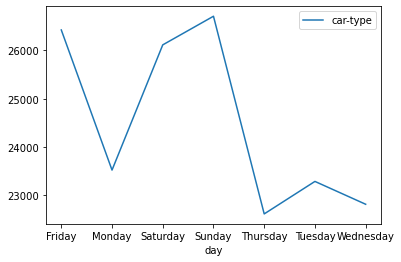

In [58]:
# this attempt did not work to separate out cars by type
graph = data.set_index('day')
print(graph.head())
graph.groupby('day').count()['car-type'].plot(legend=True)

In [40]:
g = data.groupby('month')['car-type'].value_counts()
g.head()


month    
Apr    2P    1469
       1      989
       2      863
       3      418
       4      416
Name: car-type, dtype: int64

<AxesSubplot:xlabel='month,None'>

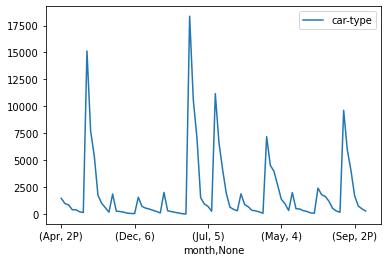

In [41]:
g.plot(legend=True)

In [46]:
p = data.groupby(['month', 'car-type']).size()
p.head()

month  car-type
Apr    1            989
       2            863
       2P          1469
       3            418
       4            416
dtype: int64

<AxesSubplot:xlabel='month'>

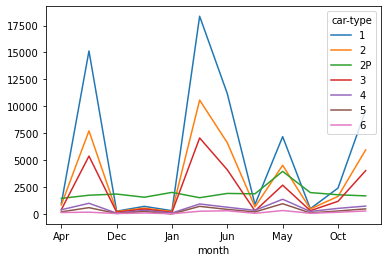

In [48]:
p.unstack().plot(legend=True)

<AxesSubplot:xlabel='days'>

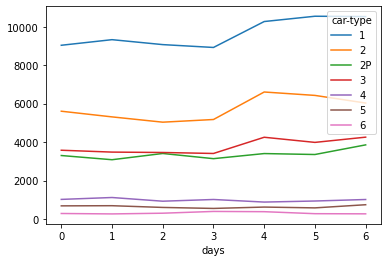

In [50]:
l = data.groupby(['days','car-type']).size()
l.unstack().plot(legend=True)

<AxesSubplot:xlabel='month,days'>

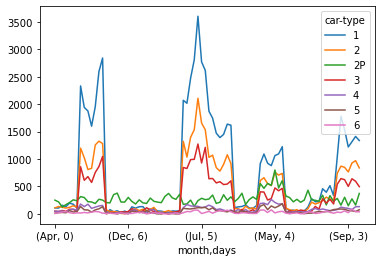

In [52]:
m = data.groupby(['month','days','car-type']).size()
m.unstack().plot(legend=True)

<AxesSubplot:xlabel='gate-name'>

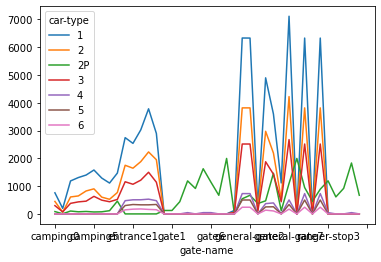

In [54]:
m = data.groupby(['gate-name','car-type']).size()
m.unstack().plot(legend=True)

<AxesSubplot:xlabel='hours'>

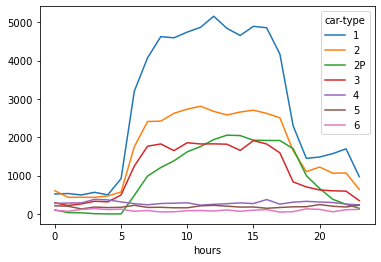

In [57]:
n = data.groupby(['hours', 'car-type']).size()
n.unstack().plot(legend=True)

In [67]:
# another heatmap attempt. not having luck with not having duplicate indexes...???
data["months2"] = pd.Categorical(data["month"], data.month.unique())
data["days2"] = pd.Categorical(data["days"], data.days.unique())
data["cars2"] = pd.Categorical(data["car-type"], data["car-type"].unique())
car_matrix = data.pivot("months2","days","car-type")
r = sns.heatmap (car_matrix, cmap='BuPu')

ValueError: Index contains duplicate entries, cannot reshape